# Отток клиентов

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Предоставлены исторические данные о поведении клиентов и расторжении договоров с банком. 

Необходимо построить модель с предельно большим значением *F1*-меры, близким к 0.59. Проверить *F1*-меру на тестовой выборке.

Дополнительно измерить *AUC-ROC*, сравнить её значение с *F1*-мерой.

Источник данных: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)


В нашем распоряжении данные клиентов банка: имя клиента, возраст, пол, страна, рейтинг, сколько лет человек является клиентом банка, баланс на счёте, зарплата и др.<br>

В рамках проекта предстоит:

- подготовить данные
- обработать пропущенные значения в столбцах
- преобразовать категориальные признаки в численные
- масштабировать численные признаки
- построить разные модели и изучить их метрики с дисбалансом
- построить разные модели и изучить их метрики, устранив дисбаланс
- проверить модель на тестовой выборке 

В данных представлены следующие признаки:

- RowNumber — индекс строки в данных
- CustomerId — уникальный идентификатор клиента
- Surname — фамилия
- CreditScore — кредитный рейтинг
- Geography — страна проживания
- Gender — пол
- Age — возраст
- Tenure — сколько лет человек является клиентом банка
- Balance — баланс на счёте
- NumOfProducts — количество продуктов банка, используемых клиентом
- HasCrCard — наличие кредитной карты
- IsActiveMember — активность клиента
- EstimatedSalary — предполагаемая зарплата

Целевой признак - Exited — факт ухода клиента

## Подготовка данных

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score, classification_report, roc_auc_score, roc_curve
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils import shuffle

RANDOM_STATE = 12345

In [2]:
data_churn = pd.read_csv('/datasets/Churn.csv')
data_churn.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


In [3]:
data_churn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


В признаке "Tenure" есть пропущенные значения, проверим другие признаки, где "Tenure" nan:


In [4]:
data_churn[pd.isnull(data_churn.Tenure)]

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
30,31,15589475,Azikiwe,591,Spain,Female,39,NaN,0.00,3,1,0,140469.38,1
48,49,15766205,Yin,550,Germany,Male,38,NaN,103391.38,1,0,1,90878.13,0
51,52,15768193,Trevisani,585,Germany,Male,36,NaN,146050.97,2,0,0,86424.57,0
53,54,15702298,Parkhill,655,Germany,Male,41,NaN,125561.97,1,0,0,164040.94,1
60,61,15651280,Hunter,742,Germany,Male,35,NaN,136857.00,1,0,0,84509.57,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9944,9945,15703923,Cameron,744,Germany,Male,41,NaN,190409.34,2,1,1,138361.48,0
9956,9957,15707861,Nucci,520,France,Female,46,NaN,85216.61,1,1,0,117369.52,1
9964,9965,15642785,Douglas,479,France,Male,34,NaN,117593.48,2,0,0,113308.29,0
9985,9986,15586914,Nepean,659,France,Male,36,NaN,123841.49,2,1,0,96833.00,0


Никаких аномалий не замечено, заполним их медианным значением:

In [5]:
data_churn['Tenure'] = data_churn['Tenure'].fillna(data_churn['Tenure'].median())
data_churn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


In [6]:
data_churn.describe()

,RowNumber,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,10000.00000,1.000000e+04,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,5000.50000,1.569094e+07,650.528800,38.921800,4.99790,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,2886.89568,7.193619e+04,96.653299,10.487806,2.76001,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,1.00000,1.556570e+07,350.000000,18.000000,0.00000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,2500.75000,1.562853e+07,584.000000,32.000000,3.00000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,5000.50000,1.569074e+07,652.000000,37.000000,5.00000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,7500.25000,1.575323e+07,718.000000,44.000000,7.00000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,10000.00000,1.581569e+07,850.000000,92.000000,10.00000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


Преобразуем категориальные признаки в численные с помощью техники прямого кодирования:

In [7]:
data_churn_ohe = pd.get_dummies(data_churn, drop_first=True)

features = data_churn_ohe.drop('Exited', axis=1)
target = data_churn_ohe['Exited']

features_train, features_valid_test, target_train, target_valid_test= train_test_split(features, target, test_size=0.4, random_state=RANDOM_STATE, stratify=target)
features_valid, features_test, target_valid, target_test = train_test_split(features_valid_test, target_valid_test, test_size=0.5, random_state=RANDOM_STATE, stratify=target_valid_test)

features_train.head()

,RowNumber,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,...,Surname_Zotova,Surname_Zox,Surname_Zubarev,Surname_Zubareva,Surname_Zuev,Surname_Zuyev,Surname_Zuyeva,Geography_Germany,Geography_Spain,Gender_Male
2837,2838,15703059,549,49,6.0,124829.16,1,0,1,93551.36,...,0,0,0,0,0,0,0,1,0,0
9925,9926,15605672,694,38,5.0,195926.39,1,1,1,85522.84,...,0,0,0,0,0,0,0,0,0,0
8746,8747,15577905,660,34,8.0,106486.66,2,0,1,182262.66,...,0,0,0,0,0,0,0,0,0,1
660,661,15592937,632,41,5.0,81877.38,1,1,1,33642.21,...,0,0,0,0,0,0,0,1,0,0
3610,3611,15711716,580,56,1.0,131368.30,1,1,0,106918.67,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
# промасштабируем численные признаки
numeric = ['CreditScore', 'Balance', 'EstimatedSalary', 'Age']

scaler = StandardScaler()
scaler.fit(features_train[numeric])
features_train[numeric] = scaler.transform(features_train[numeric])
features_valid[numeric] = scaler.transform(features_valid[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])

**Выводы:** 
Изучены данные по клиентам банка. В столбеце "Tenure" устранены пропущенные значения. Преобразованы категориальные признаки в численные с помощью техники прямого кодирования. Промасштабированы численные признаки.

## Исследование задачи

Посмотрим, какие метрики выдают разные модели без дополнительных установок.

Модель логистической регрессии:

In [ ]:
model = LogisticRegression(random_state=RANDOM_STATE, solver='liblinear')
model.fit(features_train, target_train)
predicted_valid = model.predict(features_valid)

report = classification_report(target_valid, predicted_valid)
print(report)

               precision    recall  f1-score   support

           0       0.80      1.00      0.89      1592
           1       0.00      0.00      0.00       408

    accuracy                           0.80      2000
    

In [12]:
#посчитаем площадь под ROC-кривой
probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
print(auc_roc)

0.5200281431668143


Придадим объектам класса "1" больший вес:

In [13]:
model = LogisticRegression(random_state=RANDOM_STATE, solver='liblinear', class_weight='balanced')
model.fit(features_train, target_train)
predicted_valid = model.predict(features_valid)

report = classification_report(target_valid, predicted_valid)
print(report)

              precision    recall  f1-score   support

           0       0.90      0.69      0.78      1592
           1       0.37      0.71      0.49       408

    accuracy                           0.69      2000
   macro avg       0.64      0.70      0.63      2000
weighted avg       0.79      0.69      0.72      2000



In [14]:
#посчитаем площадь под ROC-кривой
probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
print(auc_roc)

0.7570280939008771


Модель дерева решений:

In [15]:
model = DecisionTreeClassifier(random_state=RANDOM_STATE)
model.fit(features_train, target_train)
predicted_valid = model.predict(features_valid) 

report = classification_report(target_valid, predicted_valid)
print(report)

              precision    recall  f1-score   support

           0       0.88      0.90      0.89      1592
           1       0.57      0.53      0.55       408

    accuracy                           0.82      2000
   macro avg       0.72      0.71      0.72      2000
weighted avg       0.82      0.82      0.82      2000



In [16]:
#посчитаем площадь под ROC-кривой
probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
print(auc_roc)

0.7131983446644989


Придадим объектам класса "1" больший вес:

In [17]:
model = DecisionTreeClassifier(random_state=RANDOM_STATE, class_weight='balanced')
model.fit(features_train, target_train)
predicted_valid = model.predict(features_valid) 

report = classification_report(target_valid, predicted_valid)
print(report)

              precision    recall  f1-score   support

           0       0.89      0.89      0.89      1592
           1       0.56      0.57      0.57       408

    accuracy                           0.82      2000
   macro avg       0.73      0.73      0.73      2000
weighted avg       0.82      0.82      0.82      2000



In [18]:
#посчитаем площадь под ROC-кривой
probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
print(auc_roc)

0.7299179722140112


Попробуем подобрать гиперпараметры для модели дерева решений:

In [19]:
# best_model = None
# best_result = 0.57
# best_depth = 0


# for depth in range (1, 12):
#     model = DecisionTreeClassifier(random_state=RANDOM_STATE, max_depth=depth, class_weight='balanced')
#     model.fit(features_train, target_train)
#     predicted_valid = model.predict(features_valid) 
#     result = f1_score(target_valid, predicted_valid) 
#     if result > best_result:
#         best_model = model
#         best_result = result
#         best_depth = depth
# 
# print("F1 наилучшей модели на валидационной выборке:", best_result, "Максимальная глубина:", best_depth)

In [20]:
model = DecisionTreeClassifier(max_depth=11, random_state=RANDOM_STATE, class_weight='balanced')
model.fit(features_train, target_train)
predicted_valid = model.predict(features_valid) 

report = classification_report(target_valid, predicted_valid)
print(report)

              precision    recall  f1-score   support

           0       0.91      0.83      0.87      1592
           1       0.50      0.68      0.58       408

    accuracy                           0.80      2000
   macro avg       0.71      0.75      0.72      2000
weighted avg       0.83      0.80      0.81      2000



Модель случайного леса:

In [21]:
model = RandomForestClassifier(random_state=RANDOM_STATE)
model.fit(features_train, target_train)
predicted_valid = model.predict(features_valid) 

report = classification_report(target_valid, predicted_valid)
print(report)

              precision    recall  f1-score   support

           0       0.86      0.98      0.92      1592
           1       0.85      0.39      0.53       408

    accuracy                           0.86      2000
   macro avg       0.86      0.69      0.73      2000
weighted avg       0.86      0.86      0.84      2000



In [22]:
#посчитаем площадь под ROC-кривой
probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
print(auc_roc)

0.8452387550497584


Придадим объектам класса "1" больший вес:

In [23]:
model = RandomForestClassifier(random_state=RANDOM_STATE, class_weight='balanced')
model.fit(features_train, target_train)
predicted_valid = model.predict(features_valid) 

report = classification_report(target_valid, predicted_valid)
print(report)

              precision    recall  f1-score   support

           0       0.85      0.98      0.91      1592
           1       0.85      0.34      0.49       408

    accuracy                           0.85      2000
   macro avg       0.85      0.66      0.70      2000
weighted avg       0.85      0.85      0.83      2000



In [24]:
#посчитаем площадь под ROC-кривой
probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
print(auc_roc)

0.8539357325844911


Попробуем подобрать гиперпараметры для модели случайного леса:

In [25]:
# best_model = None
# best_result = 0.59
# best_est = 0
# best_depth = 0

# for est in range(1, 100):
#     for depth in range (1, 30):
#         model = RandomForestClassifier(n_estimators=est, max_depth=depth, random_state=RANDOM_STATE, class_weight='balanced')
#         model.fit(features_train, target_train)
#         predicted_valid = model.predict(features_valid)
#         result = f1_score(target_valid, predicted_valid) 
#         if result > best_result:
#             best_model = model
#             best_result = result
#             best_est = est
#             best_depth = depth
# print("F1 наилучшей модели на валидационной выборке:", best_result, "Количество деревьев:", best_est, "Максимальная глубина:", best_depth)

In [26]:
model = RandomForestClassifier(n_estimators=64, max_depth=27, random_state=RANDOM_STATE, class_weight='balanced')
model.fit(features_train, target_train)
predicted_valid = model.predict(features_valid) 

report = classification_report(target_valid, predicted_valid)
print(report)

              precision    recall  f1-score   support

           0       0.91      0.86      0.88      1592
           1       0.54      0.67      0.60       408

    accuracy                           0.82      2000
   macro avg       0.73      0.76      0.74      2000
weighted avg       0.84      0.82      0.83      2000



**Выводы:**
 По результатам исследования лучший результат по F1=0.57 после взвешивания классов показала модель алгоритма DecisionTreeClassifier (до взвешивания F1=0.57, AUC-ROC=0.73). Модель логистической регрессии показала после взвешивания классов F1=0.51, AUC-ROC=0.53. Случайный лес дал результат F1=0.53, AUC-ROC=0.85. После подбора гиперпараметров модель случайного леса показала наилучший результат F1=0.62.

## Борьба с дисбалансом

In [27]:
data_churn['Exited'].value_counts()

0    7963
1    2037
Name: Exited, dtype: int64

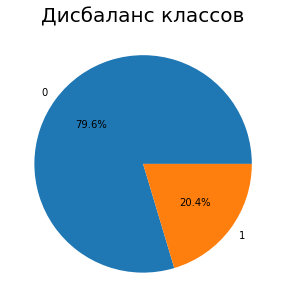

In [28]:
data_churn['Exited'].value_counts().plot(kind='pie', figsize=(10,5), autopct='%1.1f%%')
plt.title('Дисбаланс классов', fontsize=20)
plt.ylabel('');

Увеличим выборку для класса "1" техникой upsampling, в качестве коэффициента увеличения возьмем значение 4 (так как разница между классами отличается примерно в 4 раза):

In [29]:
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=RANDOM_STATE)
    
    return features_upsampled, target_upsampled

features_upsampled, target_upsampled = upsample(features_train, target_train, 4)

Используем новую выборку для обучения алгоритмом логистической регрессии:

In [30]:
model = LogisticRegression(random_state=RANDOM_STATE, solver='liblinear')
model.fit(features_upsampled, target_upsampled)
predicted_valid = model.predict(features_valid)

report = classification_report(target_valid, predicted_valid)
print(report)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1592
           1       0.20      1.00      0.34       408

    accuracy                           0.20      2000
   macro avg       0.10      0.50      0.17      2000
weighted avg       0.04      0.20      0.07      2000



/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [31]:
#посчитаем площадь под ROC-кривой
probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
print(auc_roc)

0.47997185683318555


Используем новую выборку для обучения алгоритмом дерева решений:

In [32]:
model = DecisionTreeClassifier(random_state=RANDOM_STATE)
model.fit(features_upsampled, target_upsampled)
predicted_valid = model.predict(features_valid) 

report = classification_report(target_valid, predicted_valid)
print(report)

              precision    recall  f1-score   support

           0       0.89      0.87      0.88      1592
           1       0.54      0.58      0.56       408

    accuracy                           0.81      2000
   macro avg       0.71      0.73      0.72      2000
weighted avg       0.82      0.81      0.81      2000



In [33]:
#посчитаем площадь под ROC-кривой
probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
print(auc_roc)

0.7269681742043552


Используем новую выборку для обучения алгоритмом случайного леса:

In [34]:
model = RandomForestClassifier(random_state=RANDOM_STATE)
model.fit(features_upsampled, target_upsampled)
predicted_valid = model.predict(features_valid) 

report = classification_report(target_valid, predicted_valid)
print(report)

              precision    recall  f1-score   support

           0       0.88      0.95      0.91      1592
           1       0.72      0.48      0.57       408

    accuracy                           0.85      2000
   macro avg       0.80      0.71      0.74      2000
weighted avg       0.84      0.85      0.84      2000



In [35]:
#посчитаем площадь под ROC-кривой
probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
print(auc_roc)

0.8564298206719875


Уменьшим выборку для класса "0" техникой downsampling, в качестве коэффициента уменьшения возьмем значение 0,26 (так как отношение между классами равно примерно 0,26):

In [36]:
#Уменьшение выборки
def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=RANDOM_STATE)] + [features_ones])
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=RANDOM_STATE)] + [target_ones])
    
    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=RANDOM_STATE)
    
    return features_downsampled, target_downsampled

features_downsampled, target_downsampled = downsample(features_train, target_train, 0.26)

Используем новую выборку для обучения алгоритмом дерева решений:

In [37]:
model = DecisionTreeClassifier(random_state=RANDOM_STATE)
model.fit(features_downsampled, target_downsampled)
predicted_valid = model.predict(features_valid) 

report = classification_report(target_valid, predicted_valid)
print(report)

              precision    recall  f1-score   support

           0       0.91      0.76      0.83      1592
           1       0.43      0.71      0.53       408

    accuracy                           0.75      2000
   macro avg       0.67      0.73      0.68      2000
weighted avg       0.81      0.75      0.77      2000



In [38]:
#посчитаем площадь под ROC-кривой
probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
print(auc_roc)

0.7320240910434526


Используем новую выборку для обучения алгоритмом случайного леса:

In [39]:
model = RandomForestClassifier(random_state=RANDOM_STATE)
model.fit(features_downsampled, target_downsampled)
predicted_valid = model.predict(features_valid) 

report = classification_report(target_valid, predicted_valid)
print(report)

              precision    recall  f1-score   support

           0       0.93      0.80      0.86      1592
           1       0.49      0.77      0.60       408

    accuracy                           0.79      2000
   macro avg       0.71      0.78      0.73      2000
weighted avg       0.84      0.79      0.80      2000



In [40]:
#посчитаем площадь под ROC-кривой
probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
print(auc_roc)

0.8526132500738989


Подберем лучшие гиперпараметры для модели случайного леса:

In [41]:
# best_model = None
# best_result = 0.59
# best_est = 0
# best_depth = 0

# for est in range(1, 100):
#     for depth in range (1, 30):
#         model = RandomForestClassifier(n_estimators=est, max_depth=depth, random_state=RANDOM_STATE)
#         model.fit(features_downsampled, target_downsampled)
#         predicted_valid = model.predict(features_valid)
#         result = f1_score(target_valid, predicted_valid) 
#         if result > best_result:
#             best_model = model
#             best_result = result
#             best_est = est
#             best_depth = depth
# print("F1 наилучшей модели на валидационной выборке:", best_result, "Количество деревьев:", best_est, "Максимальная глубина:", best_depth)

In [42]:
model = RandomForestClassifier(n_estimators=65, max_depth=22, random_state=RANDOM_STATE)
model.fit(features_downsampled, target_downsampled)
predicted_valid = model.predict(features_valid)
report = classification_report(target_valid, predicted_valid)
print(report)

              precision    recall  f1-score   support

           0       0.93      0.80      0.86      1592
           1       0.49      0.78      0.60       408

    accuracy                           0.79      2000
   macro avg       0.71      0.79      0.73      2000
weighted avg       0.84      0.79      0.81      2000



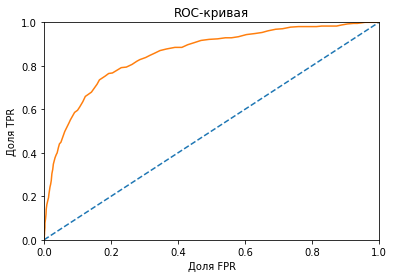

In [43]:
#построим ROC-кривую
fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid)

plt.figure()


plt.plot([0, 1], [0, 1], linestyle='--')

plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('Доля FPR')
plt.ylabel('Доля TPR')
plt.title('ROC-кривая')
plt.show() 

**Выводы:** После уменьшения выборки модель RandomForestClassifier показала хорошие результаты, F1=0.60, Accuracy=0.79, площадь под ROC-кривой AUC-ROC=0.85.

## Тестирование модели

In [44]:
model = RandomForestClassifier(n_estimators=64, max_depth=27, random_state=RANDOM_STATE, class_weight='balanced')
model.fit(features_train, target_train)

predicted_test = model.predict(features_test) 

report = classification_report(target_test, predicted_test)
print(report)

              precision    recall  f1-score   support

           0       0.89      0.86      0.88      1593
           1       0.52      0.60      0.56       407

    accuracy                           0.81      2000
   macro avg       0.71      0.73      0.72      2000
weighted avg       0.82      0.81      0.81      2000



In [45]:
#посчитаем площадь под ROC-кривой
probabilities_test = model.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]

auc_roc = roc_auc_score(target_test, probabilities_one_test)
print(auc_roc)

0.8198830571711929


**Выводы:** На тестовой выборке мы получили F1=0.58, Accuracy=0.82.

**Итоговые выводы:** 
Целью проекта являлось достижение метрики F1, близкой к 0,59.

В ходе проекта были обучены модели по алгоритмам:
1. Логистической регрессии
2. Дерева решений
3. Случайного дерева

Обучение модели без учёта дисбаланса не привело к нужным результатам. Максимально достигнутое значение F1-меры 0,55 обеспечила модель дерева решений.

Применены методы балансировки:
1. Взвешивание классов
2. Уменьшение выборки
3. Увеличение выборки

Обучение модели, учитывая дисбаланс классов, позволило достичь хороший результат F1-меры. Наилучший результат F1=0,62 получено обучением модели с помощью алгоритма случайного дерева с методом взвешивания классов. На тестовой выборке мы получили F1=0.58, Accuracy=0.82.